### Packages  

First you need to install all packages which are compatible with python version 3. 

Installed packages need to be upgraded.

In [ ]:
#!pip3 install matplotlib --user
#!pip3 install gekko --user
#!pip3 install scipy --user
#!pip3 install seaborn --user 
#!pip3 install sklearn --user
#!pip3 install tensorflow --user


In [1]:
import sys
import os

py_file_location = "..."
sys.path.append(os.path.abspath(py_file_location))


In [2]:
from library import *
from model_DL import *
from functions import *
from metrics import *
from data_generator import *
from losses import *
from optimization import *
from parameters import *


Choose GPU if it is available 

In [ ]:
print(tf.config.list_physical_devices())
tf.device('CPU:0')

### Channel gain creation

First, you can choose the type of channel to perform the simulations. To do this, simply select the type by entering the number of the desired channel type 

In [ ]:
GPP, GPR, GRP, GSS, GSR, GRS, GSP, GPS = channel_type() # train data-type

In [ ]:
t_GPP, t_GPR, t_GRP, t_GSS, t_GSR, t_GRS, t_GSP, t_GPS = channel_type() # test data-type

### Filter Data

After data creation, it must be filtred to avoide the division by zero on the custom loss function for that we maintint only channal gain greater then a fixed threshold s.


In [ ]:
GRP, GPP, GSR, GPR, GSS, GRS, GSP, GPS = data_filter(GRP, GPP, GSR, GPR, GSS, GRS, GSP, GPS)
t_GRP, t_GPP, t_GSR, t_GPR, t_GSS, t_GRS, t_GSP, t_GPS = data_filter(t_GRP, t_GPP, t_GSR, t_GPR, t_GSS, t_GRS, t_GSP, t_GPS)

### Dataset
Create the dataset and save it on a specific path

1 - data size must be fixed

In [11]:
Nbr_train = 1000000
Nbr_test = 200000 #20000

outfile = 'Dataset/' # choose your path 

$stack\ training\ data$

In [ ]:

DS_train = stack_dtrain(GRP[:Nbr_train], GPP[:Nbr_train], GSR[:Nbr_train], GPR[:Nbr_train], GSS[:Nbr_train], GRS[:Nbr_train], GSP[:Nbr_train], GPS[:Nbr_train])

np.savez(outfile+'dataset_train', DS_train)

print("\n training set generation finished")


### Bruteforce
The bruteforce method is applied only for the test set to use it as a benchmark with the DNN predicted results

$stack\ test\ data$

In [ ]:
bf_results = mult_res(BF_A, t_GRP[:Nbr_test], t_GPP[:Nbr_test], t_GSR[:Nbr_test], t_GPR[:Nbr_test], t_GSS[:Nbr_test], t_GRS[:Nbr_test], t_GSP[:Nbr_test], t_GPS[:Nbr_test])

DS = stack_dtest(t_GRP[:Nbr_test], t_GPP[:Nbr_test], t_GSR[:Nbr_test], t_GPR[:Nbr_test], t_GSS[:Nbr_test], t_GRS[:Nbr_test], t_GSP[:Nbr_test], t_GPS[:Nbr_test], bf_results[:,8], bf_results[:,9], bf_results[:,10], bf_results[:,11])

np.savez(outfile+'dataset_test', DS)

print("\n test set generation finished")


### Split dataset
if dataset is already created (load it)

In [3]:
### Train ###

dataset_train = np.load('Dataset/dataset_train.npz')
dataset_train.files
dataset_train = dataset_train['arr_0']

### Test ### 
dataset_test = np.load('Dataset/dataset_test_sigma_7_dim_10_vf.npz')
dataset_test.files
dataset_test = dataset_test['arr_0']

x_train = dataset_train[:,0:8]

x_test, y_test = dataset_test[:,0:8], dataset_test[:,8:12]



In [4]:
x_test.shape

(200000, 8)

### Training phase 

In [ ]:
metrics = [Achievable_Rate(tau), QoS_Violation(tau), Primary_Achievable_Rate_Degradation, Primary_ARD_Percentage(tau)] 

Epochs = 1000 # Epochs number

BS = 4096 # Batch_size

VS = 0.2 # Validation set

LD = {'10_-1':10**-1, '10_-0.75':10**-0.75, '10_-0.5':10**-0.5, '10_-0.25':10**-0.25, '10_0':10**0, '10_0.25':10**0.25, '10_0.5':10**0.5, '10_0.75':10**0.75, '10_1':10**1, '10_1.25':10**1.25, '10_1.5':10**1.5, '10_1.75':10**1.75, '10_2':10**2}

LR = 10**-4 #{'10_-4':10**-4}

#root_dir ='DNN'

for ld_k, ld_v in LD.items():
 
  #Create a new directory (a folder) in Drive

  lambda_dir = root_dir+'/lambda = '+ld_k+'/weights/'
  
  history_dir = root_dir+'/lambda = '+ld_k+'/history/'
  
  tf.io.gfile.makedirs(lambda_dir)
    
  tf.io.gfile.makedirs(history_dir)

  #for lr_k, lr_v in LR.items(): add a loop if browsing learning rate needed

  model = get_model_DF(x_train, loss_DF_WN(ld_v,tau), metrics,'sigmoid', custom_sigmoid, custom_sigmoid, LR) #lr_v
  history = model.fit(x_train, x_train, epochs=Epochs, batch_size=BS, validation_split = VS)

  model.save(lambda_dir+ld_k+'.h5')
  np.save(history_dir+ld_k+'.npy',history.history)



### Performance within the test set 

the figure below represent the intersted results of $\lambda$ hyperparameters  = 0.5 and $\lambda$ = 2.

In [5]:
LD = {'10_0.5':10**0.5,'10_2':10**2}


In [6]:
loss_history =  history_extraction(LD, 'loss')
val_loss_history = history_extraction(LD, 'val_loss')

#rate_history =  history_extraction(LD, 'throughput')
#val_rate_history = history_extraction(LD, 'val_throughput')

#pard_history =  history_extraction(LD, 'Primary_Achievable_Rate_Degradation')
#val_pard_history = history_extraction(LD, 'val_Primary_Achievable_Rate_Degradation')

#Outage_history = history_extraction(LD, 'Primary_ARDP') outage ? !! 
#val_Outage_history = history_extraction(LD, 'val_Primary_ARDP') !! 


#pard_history, pard_history = percentage(pard_history), percentage(val_pard_history)

#QoS_history, val_QoS_history = percentage(QoS_history), percentage(val_QoS_history)

Evolution of the training and validation loss function

y_lim parameter must be modified for a better visualization 

In [ ]:
#'Model loss' : 

train_curve(loss_history, val_loss_history, 'Loss', [0,1000], [-0.20,0], LD, '/Figures/')

# 'Secondary achievable rate' :

train_curve(rate_history, val_rate_history, r'Rate $(bit/s/Hz)$', [0,10], [-0.20,0], LD, '/Figures/') 

# Primary network violation : 

train_curve(Outage_history, val_Outage_history, 'Outage (%)', [0,10], [-0.20,0], LD, '/Figures/') 

# Instantaneous primary acheivable rate degradation :

train_curve(pard_history, val_pard_history, 'Mean $\ D_{i}$ (%)', [0,10], [-0.20,0], LD, '/Figures/')

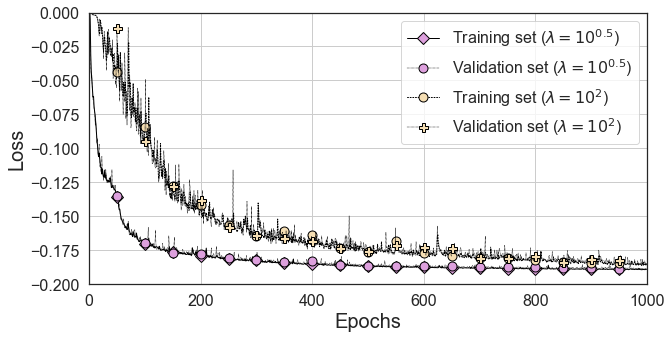

In [13]:
#'Model loss' : 

train_curve(loss_history, val_loss_history, 'Loss', [0,1000], [-0.20,0], LD, '/Figures/')

# 'Secondary achievable rate' :

#train_curve(rate_history, val_rate_history, r'Rate $(bit/s/Hz)$', [0,10], [-0.20,0], LD, '/Figures/') 

# Primary network violation : 

#train_curve(Outage_history, val_Outage_history, 'Outage (%)', [0,10], [-0.20,0], LD, '/Figures/') 

# Instantaneous primary acheivable rate degradation :

#train_curve(pard_history, val_pard_history, 'Mean $\ D_{i}$ (%)', [0,10], [-0.20,0], LD, '/Figures/')

### Average and maximum primary rate degradation and average degradation when in outage as functions of $
\lambda$

####Load model (weights and training history)

In [6]:
# final version

LD = {'10_-1':10**-1,'10_-0.75':10**-0.75,'10_-0.5':10**-0.5,'10_-0.25':10**-0.25,'10_0':10**0,'10_0.25':10**0.25,'10_0.5':10**0.5,'10_0.75':10**0.75,'10_1':10**1,'10_1.25':10**1.25,'10_1.5':10**1.5,'10_1.75':10**1.75,'10_2':10**2}

LR = {'10_-4':10**-4}

rate_gap, outage, pnd_average, pnd_max, delta_out = results_analysis(x_test, y_test, LD, LR)

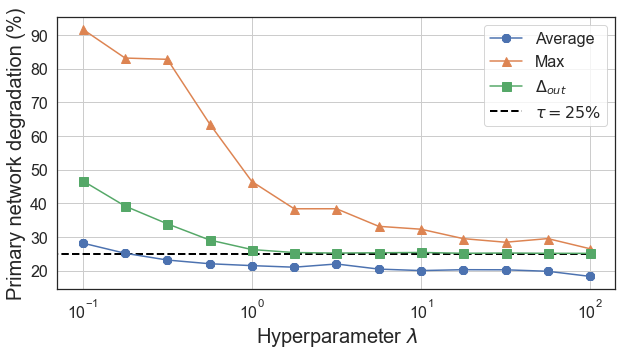

In [7]:

references = np.round(np.array([10**-1,10**-0.75,10**-0.5,10**-0.25,10**0,10**0.25,10**0.5,10**0.75,10**1,10**1.25,10**1.5,10**1.75,10**2]), decimals=4)

rate_gap_plt = np.round(np.array(rate_gap).transpose().reshape(13), decimals=4)

outage_plt = np.round(np.array(outage).transpose().reshape(13), decimals=4)

pnd_average_plt = np.round(np.array(pnd_average).transpose().reshape(13), decimals=4)

pnd_max_plt = np.round(np.array(pnd_max).transpose().reshape(13), decimals=4)

delta_out_plt = np.round(np.array(delta_out).transpose().reshape(13), decimals=4)

plt.rcParams["figure.figsize"] = (10,5)
sns.set(style='white')
fig = plt.figure(1)

plt.grid()
xs = np.linspace(1, 21, 100)

plt.hlines(y=25, xmin=0, xmax=len(xs), colors='black', linestyles='--', lw=2, label=r'$\tau = 25\%$')

plt.plot(references, pnd_average_plt*100, label = 'Average', marker='8',markersize=9)

plt.plot(references, pnd_max_plt*100, label= 'Max', marker='^',markersize=9)

plt.plot(references, delta_out_plt*100, label= r'$\Delta_{out}$', marker='s',markersize=9)

#plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'Hyperparameter $\lambda$',fontsize= 20)
plt.ylabel('Primary network degradation (%)',fontsize= 20)
plt.xticks(fontsize=16) 
plt.yticks(fontsize=16) 
#plt.xticks(references,['$10^{-1}$', '$10^{-0.75}$','$10^{-0.5}$', '$10^{-0.25}$','$10^{0}$', '$10^{0.25}$','$10^{0.5}$', '$10^{0.75}$','$10^{1}$','$10^{1.25}$','$10^{1.5}$','$10^{1.75}$','$10^{2}$'])
plt.legend(loc = 'best', fontsize= 16)
fig.savefig('stats.pdf', bbox_inches='tight')


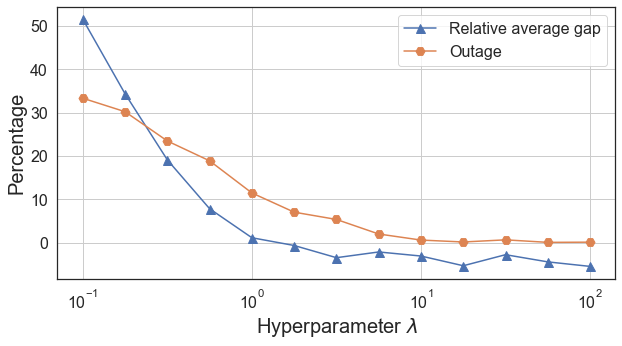

In [8]:
plt.rcParams["figure.figsize"] = (10,5)

sns.set(style='white')
fig = plt.figure(1)

plt.grid()
xs = np.linspace(1, 21, 100)

plt.plot(references, rate_gap_plt*100, label='Relative average gap', marker='^',markersize=9)
plt.plot(references, outage_plt, label = 'Outage', marker='H',markersize=9)

plt.ylabel('Percentage', fontsize= 20)
plt.xscale('log')
plt.xlabel(r'Hyperparameter $\lambda$',fontsize= 20)
plt.xticks(fontsize=16) 
plt.yticks(fontsize=16) 

#plt.xticks(A,['$10^{-1}$', '$10^{-0.75}$','$10^{-0.5}$', '$10^{-0.25}$','$10^{0}$', '$10^{0.25}$','$10^{0.5}$', '$10^{0.75}$','$10^{1}$','$10^{1.25}$','$10^{1.5}$','$10^{1.75}$','$10^{2}$'])
plt.legend(loc = 'best', fontsize= 16)
fig.savefig('RAG.pdf', bbox_inches='tight')


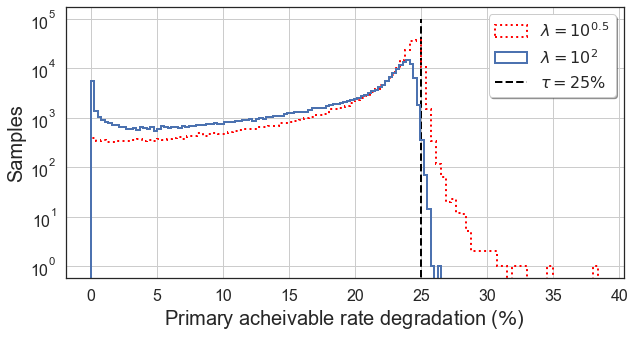

In [10]:
model = tf.keras.models.load_model(root_dir+'/lambda = 10_0.5/weights/10_0.5.h5', custom_objects={'DF_loss':loss_DF(Lambda,tau),'Primary_Achievable_Rate_Degradation':Primary_Achievable_Rate_Degradation,'Primary_ARDP':Primary_ARD_Percentage,'throughput':Achievable_Rate(tau),'V_Qos':QoS_Violation(tau), "custom_sigmoid":custom_sigmoid})

model2 = tf.keras.models.load_model(root_dir+'/lambda = 10_2/weights/10_2.h5', custom_objects={'DF_loss':loss_DF(Lambda,tau),'Primary_Achievable_Rate_Degradation':Primary_Achievable_Rate_Degradation,'Primary_ARDP':Primary_ARD_Percentage,'throughput':Achievable_Rate(tau),'V_Qos':QoS_Violation(tau), "custom_sigmoid":custom_sigmoid})

##### Evaluation on train set #####
predictions1 = model.predict(x_test)
predictions2 = model2.predict(x_test)

Pdd_Hist(x_test[:,0], x_test[:,1], x_test[:,6], predictions1[:,0], predictions1[:,1], predictions1[:,2], predictions2[:,0], predictions2[:,1], predictions2[:,2])
      

Stopped here

In [20]:
# modified part

def relative_avreage_gap(X, Y):
  """relative avreage gap between the predicted debit and the obtained debit based on bruteforce"""

  return (np.mean(X) - np.mean(Y))/(np.mean(Y))

def ARD_mean(Grp, Gpp, Gsp, Alpha, Pr, Ps):
  """
    Mean of Primary achievable rate degradation.

    Parameters:
      Grp: 1D Array containing Channel Gain between relay and primary receiver.
      Gpp: 1D Array containing Channel Gain between primary transmitter and primary receiver.
      Gsp: 1D Array containing Channel Gain between secondary transmitter and primary receiver.
      Alpha: 1D Array containing Alpha values.
      Pr: 1D Array containing Power of relay.
      Ps: 1D Array containing Power of secondary network.

    Returns:
      Mean for Primary achievable rate degradation
  """
  res = pdd(Grp, Gpp, Gsp, Alpha, Pr, Ps)
  res = res[res>tau]
  with warnings.catch_warnings():
    warnings.filterwarnings('error')
    try:
        mean = np.nanmean(res)
    except RuntimeWarning:
        mean = 0
  return mean

LD = {'10_-1':10**-1,'10_-0.75':10**-0.75,'10_-0.5':10**-0.5,'10_-0.25':10**-0.25,'10_0':10**0,'10_0.25':10**0.25,'10_0.5':10**0.5,'10_0.75':10**0.75,'10_1':10**1,'10_1.25':10**1.25,'10_1.5':10**1.5,'10_1.75':10**1.75,'10_2':10**2}

LR = {'10_-4':10**-4}


predicted_debit = []
predicted_debit_all = []
debit_gap, debit_gap_all = np.array([]), []

pdd_vmin, pdd_vmax, pdd_vmean, pdd_vstd = np.array([]), np.array([]), np.array([]), np.array([])
pdd_vmin_all, pdd_vmax_all, pdd_vmean_all, pdd_vstd_all = [], [], [], []
ard_mean, ard_mean_all = np.array([]), []

viloated_tau, viloated_tau_all = np.array([]), []

for ld_k in LD.keys():

  for lr_k in LR.keys():

      model = tf.keras.models.load_model(root_dir+'/lambda = '+ld_k+'/weights/'+ld_k+'.h5', custom_objects={'DF_loss':loss_DF(Lambda,tau),'Primary_Achievable_Rate_Degradation':Primary_Achievable_Rate_Degradation,'Primary_ARDP':Primary_ARD_Percentage,'throughput':Achievable_Rate(tau),'V_Qos':QoS_Violation(tau), "custom_sigmoid":custom_sigmoid})

      ##### Evaluation on test set #####
      predictions = model.predict(x_test)
    
      # debit calculation for ground truth and predicted test set
      debit_hat_test = rate(x_test[:,0], x_test[:,1], x_test[:,2], x_test[:,3],x_test[:,4], x_test[:,5], x_test[:,6], x_test[:,7], predictions[:,0], predictions[:,1], predictions[:,2])
      debit_true_test = stack_dtest(x_test[:,0], x_test[:,1], x_test[:,2], x_test[:,3],x_test[:,4], x_test[:,5], x_test[:,6], x_test[:,7], y_test[:,0], np.sqrt(y_test[:,1]), np.sqrt(y_test[:,2]), np.sqrt(y_test[:,3]))

      
      #predicted debit
  
      predicted_debit.append(debit_hat_test[:,8]) 
     
      ###### Gap Acheivable rate ######
      #Avreage debit gap between predicted and Brutefroce debit
      debit_gap = np.append(debit_gap, relative_avreage_gap(debit_hat_test[:,8], debit_true_test[:,8])) #[:,7] : extracting debit from ND array

      ###### Primary degradation Violation ######
      #  Primary degradation percentage, mean and median calculation
      # qos_violation calculation
      tau_violation_count = Tau_Violation_Number(x_test[:,0], x_test[:,1], x_test[:,6], predictions[:,0], predictions[:,1], predictions[:,2]) 

      viloated_tau = np.append(viloated_tau, Tau_Violation_percentage(x_test, tau_violation_count))
      ard_mean = np.append(ard_mean, ARD_mean(x_test[:,0], x_test[:,1], x_test[:,6], predictions[:,0], predictions[:,1], predictions[:,2]))

      # min, max, mean and std for primary debit degradation
      pdd_vmin, pdd_vmax, pdd_vmean, pdd_vstd =  np.append(pdd_vmin,pdd_min(x_test[:,0], x_test[:,1], x_test[:,6], predictions[:,0], predictions[:,1], predictions[:,2])), np.append(pdd_vmax,pdd_max(x_test[:,0], x_test[:,1], x_test[:,6], predictions[:,0], predictions[:,1], predictions[:,2])), np.append(pdd_vmean, pdd_mean(x_test[:,0], x_test[:,1], x_test[:,6], predictions[:,0], predictions[:,1], predictions[:,2])), np.append(pdd_vstd,pdd_std(x_test[:,0], x_test[:,1], x_test[:,6], predictions[:,0], predictions[:,1], predictions[:,2]))  
  # append data from the temporary list to the principal list
  debit_gap_all.append(debit_gap)

  predicted_debit_all.append(predicted_debit)
  ard_mean_all.append(ard_mean)

  viloated_tau_all.append(viloated_tau)
  pdd_vmin_all.append(pdd_vmin)
  pdd_vmax_all.append(pdd_vmax)
  pdd_vmean_all.append(pdd_vmean)
  pdd_vstd_all.append(pdd_vstd)

  # empty temporary lists
  predicted_debit = []
  debit_gap, viloated_tau = np.array([]), np.array([])

  pdd_vmin, pdd_vmax, pdd_vmean, pdd_vstd = np.array([]), np.array([]), np.array([]), np.array([])
  ard_mean = np.array([])

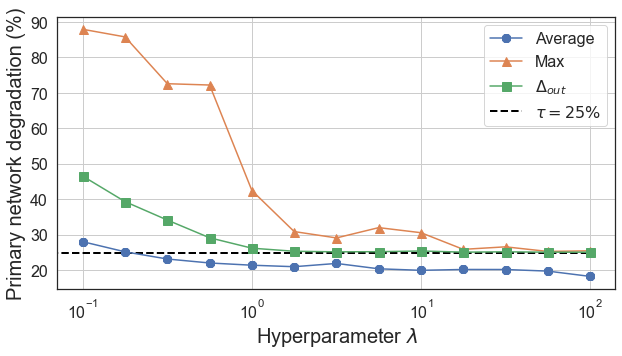

In [16]:
references = np.round(np.array([10**-1,10**-0.75,10**-0.5,10**-0.25,10**0,10**0.25,10**0.5,10**0.75,10**1,10**1.25,10**1.5,10**1.75,10**2]), decimals=4)

rate_gap_plt = np.round(np.array(rate_gap).transpose().reshape(13), decimals=4)

outage_plt = np.round(np.array(outage).transpose().reshape(13), decimals=4)

pnd_average_plt = np.round(np.array(pnd_average).transpose().reshape(13), decimals=4)

pnd_max_plt = np.round(np.array(pnd_max).transpose().reshape(13), decimals=4)

delta_out_plt = np.round(np.array(delta_out).transpose().reshape(13), decimals=4)

plt.rcParams["figure.figsize"] = (10,5)
sns.set(style='white')
fig = plt.figure(1)

plt.grid()
xs = np.linspace(1, 21, 100)

plt.hlines(y=25, xmin=0, xmax=len(xs), colors='black', linestyles='--', lw=2, label=r'$\tau = 25\%$')

plt.plot(references, pnd_average_plt*100, label = 'Average', marker='8',markersize=9)

plt.plot(references, pnd_max_plt*100, label= 'Max', marker='^',markersize=9)
plt.plot(references, delta_out_plt*100, label= r'$\Delta_{out}$', marker='s',markersize=9)

#plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'Hyperparameter $\lambda$',fontsize= 20)
plt.ylabel('Primary network degradation (%)',fontsize= 20)
plt.xticks(fontsize=16) 
plt.yticks(fontsize=16) 
#plt.xticks(references,['$10^{-1}$', '$10^{-0.75}$','$10^{-0.5}$', '$10^{-0.25}$','$10^{0}$', '$10^{0.25}$','$10^{0.5}$', '$10^{0.75}$','$10^{1}$','$10^{1.25}$','$10^{1.5}$','$10^{1.75}$','$10^{2}$'])
plt.legend(loc = 'best', fontsize= 16)
fig.savefig('stats.pdf', bbox_inches='tight')


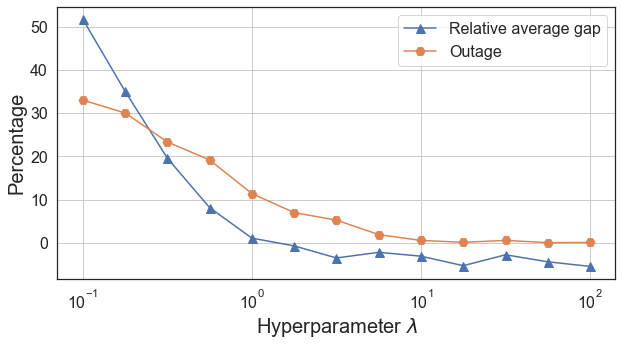

In [32]:
plt.rcParams["figure.figsize"] = (10,5)

sns.set(style='white')
fig = plt.figure(1)

plt.grid()
xs = np.linspace(1, 21, 100)

plt.plot(references, rate_gap_plt*100, label='Relative average gap', marker='^',markersize=9)
plt.plot(references, outage_plt, label = 'Outage', marker='H',markersize=9)

plt.ylabel('Percentage', fontsize= 20)
plt.xscale('log')
plt.xlabel(r'Hyperparameter $\lambda$',fontsize= 20)
plt.xticks(fontsize=16) 
plt.yticks(fontsize=16) 

#plt.xticks(A,['$10^{-1}$', '$10^{-0.75}$','$10^{-0.5}$', '$10^{-0.25}$','$10^{0}$', '$10^{0.25}$','$10^{0.5}$', '$10^{0.75}$','$10^{1}$','$10^{1.25}$','$10^{1.5}$','$10^{1.75}$','$10^{2}$'])
plt.legend(loc = 'best', fontsize= 16)
fig.savefig('RAG.pdf', bbox_inches='tight')


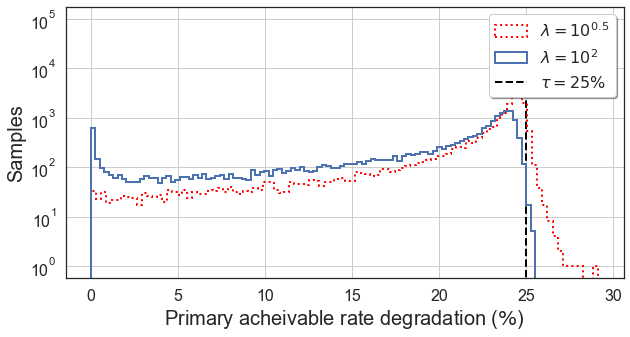

In [22]:
def Pdd_Hist(Grp, Gpp, Gsp, Alpha, Pr, Ps, Alpha2, Pr2, Ps2):
  """
    Parameters:
      Grp: Channel Gain between relay and primary receiver.
      Gpp: Channel Gain between primary transmitter and primary receiver. 
      Gsp: Channel Gain between secondary transmitter and primary receiver.
      Alpha: Array containing Alpha values.
      Pr: Array containing Power of relay.
      Ps: Array containing Power of secondary network.
    Returns:
      histogram for Primary debit degradation 
  """
  sns.set(style='white')
  plt.rcParams["figure.figsize"] = (10,5)
  
  res = pdd(Grp, Gpp, Gsp ,Alpha, Pr, Ps)*100
  res2 = pdd(Grp, Gpp, Gsp ,Alpha2, Pr2, Ps2)*100

  #fig, ax = plt.subplots(1) # Creates figure fig and add an axes, ax.
  xs = np.linspace(1, 21, 10**5)

  plt.vlines(x=25, ymin=0, ymax=len(xs), colors='black', linestyles='--', lw=2, label=r'$\tau = 25\%$')


  plt.hist(res, 100, histtype='step', ls=':', lw = 2 , color='red',label='$\lambda = 10^{0.5}$')
  plt.hist(res2, 100, histtype='step', ls='-',  lw = 2, label='$\lambda = 10^{2}$')
  
  fig = plt.figure(1)
  #plt.xlim((-1,40))
  plt.grid()
  plt.yscale('log')
  plt.xlabel('Primary acheivable rate degradation ($\%$)', fontsize= 20)
  plt.ylabel('Samples', fontsize= 20)
  plt.legend(loc='best')
  #plt.annotate(r"$\lambda$ = "+'$'+Lambda_value.replace('_','^{')+'}$', xy=(0.05,0.9),xycoords='axes fraction',
  #           fontsize=14)

  lgd = plt.legend(loc='best',
        fancybox=True, shadow=True, fontsize= 16)#title="Learning rate"
  
  plt.xticks(fontsize=16) 
  plt.yticks(fontsize=16) 

  fig.savefig('_vf''.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
  plt.show()
  plt.ion()
  plt.pause(1)
  plt.close()  



LD = {'10_-1':10**-1,'10_-0.75':10**-0.75,'10_-0.5':10**-0.5,'10_-0.25':10**-0.25,'10_0':10**0,'10_0.25':10**0.25,'10_0.5':10**0.5,'10_0.75':10**0.75,'10_1':10**1,'10_1.25':10**1.25,'10_1.5':10**1.5,'10_1.75':10**1.75,'10_2':10**2}

LR = {'10_-4':10**-4}
model = tf.keras.models.load_model(root_dir+'/lambda = 10_0.5/weights/10_0.5.h5', custom_objects={'DF_loss':loss_DF(Lambda,tau),'Primary_Achievable_Rate_Degradation':Primary_Achievable_Rate_Degradation,'Primary_ARDP':Primary_ARD_Percentage,'throughput':Achievable_Rate(tau),'V_Qos':QoS_Violation(tau), "custom_sigmoid":custom_sigmoid})

model2 = tf.keras.models.load_model(root_dir+'/lambda = 10_2/weights/10_2.h5', custom_objects={'DF_loss':loss_DF(Lambda,tau),'Primary_Achievable_Rate_Degradation':Primary_Achievable_Rate_Degradation,'Primary_ARDP':Primary_ARD_Percentage,'throughput':Achievable_Rate(tau),'V_Qos':QoS_Violation(tau), "custom_sigmoid":custom_sigmoid})

##### Evaluation on train set #####
predictions1 = model.predict(x_test)
predictions2 = model2.predict(x_test)

Pdd_Hist(x_test[:,0], x_test[:,1], x_test[:,6], predictions1[:,0], predictions1[:,1], predictions1[:,2], predictions2[:,0], predictions2[:,1], predictions2[:,2])
      

In [13]:
#yacine
n = 256
sampling = 10000
step_sampling = 100
x_min, x_max = p_min, 10
y_min, y_max = p_min, 10

def pdd(Grp, Gpp, Gsp, Alpha, Pr, Ps):
  """
      Parameters:
         Grp: 1D Array containing Alpha values.
         Gpp: 1D Array containing Gain between primary transmitter and primary receiver.
         Gsp: 1D Array containing Gain between secondary transmitter and primary receiver.
         Alpha: 1D Array containing Alpha values.
         Pr: 1D Array containing Power of relay.
         Ps: 1D Array containing Power of secondary network.
      
      Returns:
         primary debit degradation .

  """

  Rp = C((Gpp*Pp)/(Grp*Pr**2+Gsp*Ps**2+2*(np.sqrt(Gsp*Grp)*Ps*Pr*Alpha)+1))
  Rp_max = C(Gpp*Pp)
  ratio_Rp = np.nan_to_num((Rp_max-Rp)/Rp_max)
  return ratio_Rp

Rxx, Ryy = np.meshgrid(np.linspace(x_min, x_max, n),
                     np.linspace(y_min, y_max, n))

R = np.c_[Rxx.ravel(), Ryy.ravel()]


U_1 = np.ones((R.shape[0],2)) * np.array([0.25, 0.5])*10
D_1 = np.ones((R.shape[0],2)) * np.array([0.5, 0.75])*10
U_2 = np.ones((R.shape[0],2)) * np.array([0.5, 0.25])*10
D_2 = np.ones((R.shape[0],2)) * np.array([0.75, 0.5])*10

d_11 = np.linalg.norm(U_1 - D_1, axis=1)
d_12 = np.linalg.norm(U_1 - D_2, axis=1)
d_1R = np.linalg.norm(U_1 - R  , axis=1)
d_21 = np.linalg.norm(U_2 - D_1, axis=1)
d_22 = np.linalg.norm(U_2 - D_2, axis=1)
d_2R = np.linalg.norm(U_2 - R  , axis=1)
d_R1 = np.linalg.norm(R   - D_1, axis=1)
d_R2 = np.linalg.norm(R   - D_2, axis=1)

#d_11, d_12, d_1R, d_21, d_22, d_2R, , d_R2
D_test_R = np.c_[d_R1, d_11, d_2R, d_1R, d_22, d_R2, d_21, d_12].astype(np.float32)

#D_test_R = np.c_[d_11, d_12, d_1R, d_21, d_22, d_2R, d_R1, d_R2].astype(np.float32)

def channel_gain_with_gaussian_fading(d, sigma=7, alpha=3):  # channel gain model
    s = np.random.normal(0.0, sigma, d.shape)
    h = s/np.sqrt(1+np.power(d, alpha))
    g = h**2
    return g

P_R_mean = np.zeros(Rxx.shape)
P_S_mean = np.zeros(Rxx.shape)
aplha_mean = np.zeros(Rxx.shape)
D_mean = np.zeros(Rxx.shape)
S_mean = np.zeros(Rxx.shape)
pr_np = 'Relay_Plot/P_R_mean2'
ps_np = 'Relay_Plot/P_S_mean2'
alpha_np = 'Relay_Plot/alpha_mean2'
D_np = 'Relay_Plot/D_mean2'
S_np = 'Relay_Plot/S_mean2'

for i in range(int(sampling/step_sampling)):
    print(i)
    
    G = channel_gain_with_gaussian_fading((D_test_R[None,:,:]*np.ones((step_sampling,1,1))).reshape(-1,8), 7)
    Y = model.predict(G, batch_size = 4096)
    D = pdd(G[:,0], G[:,1], G[:,6], Y[:,0], Y[:,1], Y[:,2])
    S = rate(G[:,0], G[:,1], G[:,2], G[:,3], G[:,4], G[:,5], G[:,6], G[:,7], Y[:,0], Y[:,1], Y[:,2]) 
    S = S[:,8]
    del G
    alpha = Y[:,0]
    P_R = np.power(Y[:,1], 2)
    P_S = np.power(Y[:,2], 2)

    del Y
    P_R_mean = P_R_mean + np.sum(P_R.reshape((step_sampling,-1)),axis=0).reshape(Rxx.shape)
    P_S_mean = P_S_mean + np.sum(P_S.reshape((step_sampling,-1)),axis=0).reshape(Rxx.shape)
    aplha_mean = aplha_mean + np.sum(alpha.reshape((step_sampling,-1)),axis=0).reshape(Rxx.shape)
    D_mean = D_mean + np.sum(D.reshape((step_sampling,-1)),axis=0).reshape(Rxx.shape)
    S_mean = S_mean + np.sum(S.reshape((step_sampling,-1)),axis=0).reshape(Rxx.shape)   

    np.savez(pr_np, P_R_mean)
    np.savez(ps_np, P_S_mean)
    np.savez(alpha_np, aplha_mean)
    np.savez(D_np, D_mean)
    np.savez(S_np, S_mean)


P_R_mean = P_R_mean/sampling
P_S_mean = P_S_mean/sampling
aplha_mean = aplha_mean/sampling
D_mean = D_mean/sampling
S_mean = S_mean/sampling

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


<ipython-input-13-b3dcc7efec54>:25: RuntimeWarning: invalid value encountered in true_divide
  ratio_Rp = np.nan_to_num((Rp_max-Rp)/Rp_max)


18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [16]:
P_R_mean = np.load('Relay_Plot/P_R_mean2.npz')
P_S_mean = np.load('Relay_Plot/P_S_mean2.npz')
aplha_mean = np.load('Relay_Plot/alpha_mean2.npz')
D_mean = np.load('Relay_Plot/D_mean2.npz')
S_mean = np.load('Relay_Plot/S_mean2.npz')


In [17]:

P_R_mean = np.load('Relay_Plot/P_R_mean2.npz')
P_S_mean = np.load('Relay_Plot/P_S_mean2.npz')
aplha_mean = np.load('Relay_Plot/alpha_mean2.npz')
D_mean = np.load('Relay_Plot/D_mean2.npz')
S_mean = np.load('Relay_Plot/S_mean2.npz')

P_R_mean.files
P_R_mean = P_R_mean['arr_0']

P_S_mean.files
P_S_mean = P_S_mean['arr_0']

aplha_mean.files
aplha_mean = aplha_mean['arr_0']

D_mean.files
D_mean = D_mean['arr_0']
S_mean.files
S_mean = S_mean['arr_0']

n = 256
sampling = 10000
step_sampling = 100
x_min, x_max = p_min, 10
y_min, y_max = p_min, 10

Rxx, Ryy = np.meshgrid(np.linspace(x_min, x_max, n),
                     np.linspace(y_min, y_max, n))

R = np.c_[Rxx.ravel(), Ryy.ravel()]


U_1 = np.ones((R.shape[0],2)) * np.array([0.25, 0.5])*10
D_1 = np.ones((R.shape[0],2)) * np.array([0.5, 0.75])*10
U_2 = np.ones((R.shape[0],2)) * np.array([0.5, 0.25])*10

D_2 = np.ones((R.shape[0],2)) * np.array([0.75, 0.5])*10

In [18]:
P_R_mean = P_R_mean/sampling
P_S_mean = P_S_mean/sampling
aplha_mean = aplha_mean/sampling
D_mean = D_mean/sampling
S_mean = S_mean/sampling

### Average predicted relay power

<ipython-input-19-61f0b1854d9c>:11: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(cax, ticks=np.linspace(np.min(P_R_mean),np.max(P_R_mean),5), shrink=1, cmap = 'viridis')


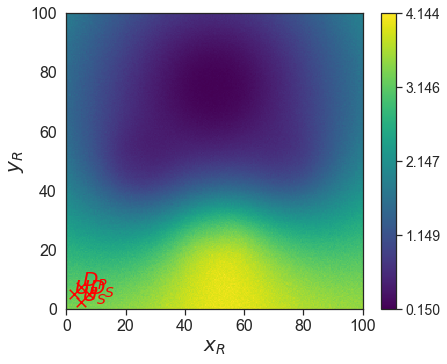

In [19]:
pos_min = p_min*10
pos_max = p_max*10

plt.figure(figsize=(6,4.8))
ax = plt.gca()
plt.tight_layout()
D_mean = D_mean*100

cax = ax.matshow(P_R_mean, origin='lower', extent=[pos_min, pos_max, pos_min, pos_max],cmap = 'viridis')
ax.xaxis.set_ticks_position('bottom')
cbar = plt.colorbar(cax, ticks=np.linspace(np.min(P_R_mean),np.max(P_R_mean),5), shrink=1, cmap = 'viridis')
for v, l in ((U_1[0,:], "$U_P$"), (U_2[0,:], "$U_S$"), (D_1[0,:], "$D_P$"), (D_2[0,:], "$D_S$")):
        plt.grid(False)
        plt.scatter(v[0], v[1], marker="x", c='red', s=90)
        plt.annotate(l, (v[0]+0.2, v[1]), c='red', fontsize=20)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(14)

plt.xlabel('$x_R$', fontsize=20)
plt.ylabel('$y_R$', fontsize=20)

plt.xticks(fontsize=16) 
plt.yticks(fontsize=16) 


plt.savefig('P_R.pdf', dpi=300, bbox_inches='tight')

### Average primary rate degradation

<ipython-input-20-2533e2a557eb>:12: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(cax, ticks=np.linspace(np.min(D_mean),np.max(D_mean),5), shrink=1, cmap = 'viridis')


<Figure size 432x345.6 with 0 Axes>

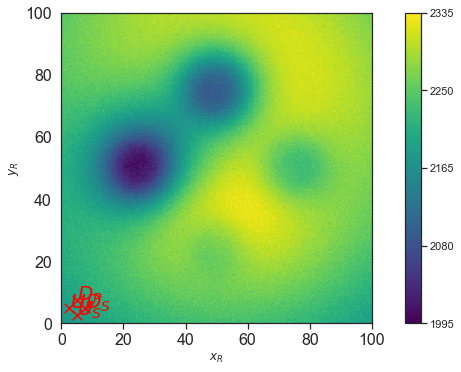

In [20]:
pos_min = p_min*10
pos_max = p_max*10
plt.figure(figsize=(6,4.8))

plt.figure()
ax = plt.gca()
plt.tight_layout()

D_mean = D_mean*100
cax = ax.matshow(D_mean, origin='lower', extent=[pos_min, pos_max, pos_min, pos_max],cmap = 'viridis')
ax.xaxis.set_ticks_position('bottom')
plt.colorbar(cax, ticks=np.linspace(np.min(D_mean),np.max(D_mean),5), shrink=1, cmap = 'viridis')
for v, l in ((U_1[0,:], "$U_P$"), (U_2[0,:], "$U_S$"), (D_1[0,:], "$D_P$"), (D_2[0,:], "$D_S$")):
        plt.grid(False)

        plt.scatter(v[0], v[1], marker="x", c='red', s=90)
        plt.annotate(l, (v[0]+0.2, v[1]), c='red', fontsize=20)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(14)

plt.xlabel('$x_R$')
plt.ylabel('$y_R$')
plt.xticks(fontsize=16) 
plt.yticks(fontsize=16) 

plt.savefig('D_Mean.pdf', dpi=300, bbox_inches='tight')

### Average secondary rate

<ipython-input-22-17e8c5813a41>:9: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(cax, ticks=np.linspace(np.min(S_mean),np.max(S_mean),5), shrink=1, cmap = 'viridis')


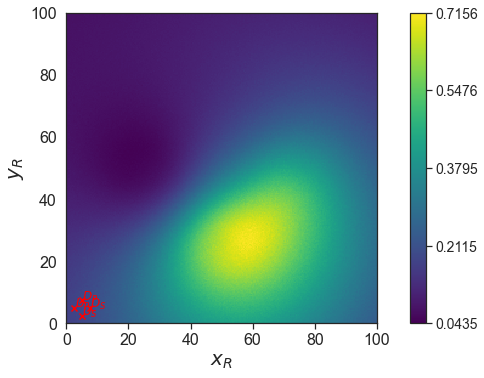

In [22]:
pos_min = p_min*10
pos_max = p_max*10
#sns.set(font_scale=5) 
plt.figure()
ax = plt.gca()
plt.tight_layout()
cax = ax.matshow(S_mean, origin='lower', extent=[pos_min, pos_max, pos_min, pos_max],cmap = 'viridis')
ax.xaxis.set_ticks_position('bottom')
cbar = plt.colorbar(cax, ticks=np.linspace(np.min(S_mean),np.max(S_mean),5), shrink=1, cmap = 'viridis')
for v, l in ((U_1[0,:], "$U_P$"), (U_2[0,:], "$U_S$"), (D_1[0,:], "$D_P$"), (D_2[0,:], "$D_S$")):
        plt.grid(False)
        plt.scatter(v[0], v[1], marker="x", c='red')
        plt.annotate(l, (v[0]+0.2, v[1]), c='red')
        
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(14)

plt.xlabel('$x_R$', fontsize=20)
plt.ylabel('$y_R$', fontsize=20)
plt.xticks(fontsize=16) 
plt.yticks(fontsize=16) 

plt.savefig('S_Mean.pdf', dpi=300, bbox_inches='tight')

####Evaluation

In [ ]:
def CDB(x, y, debit_GT):
  sns.set(style='white')
  plt.rcParams["figure.figsize"] = (10,5)
  

  colors = ['plum', 'green', 'aqua', 'wheat', 'darkred', 'grey', 'peru', 'purple', 'black', 'red']
  m = ['P','o', 'v', '^', '<', '>', 'H', '8', 'p','s']
  marker_N = 12000
  for j in range(x.shape[0]):
    for k in range(x.shape[1]):
           #sns.ecdfplot(data=x[j,k,:], label=r'Lr = '+'$'+y[k].replace('_','^{')+'}$', lw=1, ls=':', marker=m[k],markerfacecolor=colors[k], dash_capstyle='round',color = 'black', markersize=8, markevery=marker_N)

           sns.ecdfplot(data=x[j,k,:], label='Proposed method', lw=1, ls='dashed', marker='P',markerfacecolor='plum', dash_capstyle='round',color = 'black', markersize=8, markevery=marker_N)
    fig = plt.figure(1)
    sns.ecdfplot(data=debit_GT[:,8], label='Bruteforce', lw=1, ls='dashed', marker='p',markerfacecolor='red', dash_capstyle='round',color = 'black', markersize=8, markevery=marker_N)
  
    plt.grid()
    plt.xlabel("Achievable rate")
    
    plt.title(r'Cumulative distribution function '+"($ \lambda$ = "+'$'+list(LD.keys())[j].replace('_','^{')+'}$'+')',fontweight="bold")
    
    lgd = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
            fancybox=True, shadow=True, ncol=3)
    fig.savefig('/content/drive/MyDrive/Colab Notebooks/CodeVF/Results_VF/CDB/CDB_'+list(LD.keys())[j]+'.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
    fig.show()
    plt.pause(1)

In [24]:
LD = {'10_-1':10**-1,'10_-0.75':10**-0.75,'10_-0.5':10**-0.5,'10_-0.25':10**-0.25,'10_0':10**0,'10_0.25':10**0.25,'10_0.5':10**0.5,'10_0.75':10**0.75,'10_1':10**1,'10_1.25':10**1.25,'10_1.5':10**1.5,'10_1.75':10**1.75,'10_2':10**2}

LR = {'10_-4':10**-4}


def CDB(x, y, debit_GT):
  sns.set(style='white')
  plt.rcParams["figure.figsize"] = (10,5)
  
  colors = ['plum', 'green', 'aqua', 'wheat', 'darkred', 'grey', 'peru', 'purple', 'black', 'red']
  m = ['P','o', 'v', '^', '<', '>', 'H', '8', 'p','s']
  marker_N = 20000

  fig = plt.figure(1)
  #sns.ecdfplot(data=x[0,0,:], label=r'Proposed method ($\lambda = 10^{-1}$)', lw=1, ls='dashed', marker='^',markerfacecolor='darkred', dash_capstyle='round',color = 'black', markersize=9, markevery=marker_N)

  sns.ecdfplot(data=x[6,0,:], label=r'Proposed method ($\lambda = 10^{0.5}$)', lw=1, ls='solid', marker='^',markerfacecolor='plum', dash_capstyle='round',color = 'black', markersize=9, markevery=marker_N)
  sns.ecdfplot(data=x[12,0,:], label=r'Proposed method ($\lambda = 10^{2}$)', lw=1, ls='solid', marker='o',markerfacecolor='wheat', dash_capstyle='round',color = 'black', markersize=9, markevery=marker_N)

  sns.ecdfplot(data=debit_GT[:,8], label='Bruteforce', lw=1, ls='solid', marker='p',markerfacecolor='red', dash_capstyle='round',color = 'black', markersize=9, markevery=marker_N)

  plt.grid()
  plt.xlabel("Achievable rate")
  
  #plt.title('Cumulative distribution function',fontweight="bold")
  lgd = plt.legend(loc='best', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=3)
  #lgd = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
  #        fancybox=True, shadow=True, ncol=3)
  fig.savefig('CDB_2.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
  fig.show()
  plt.pause(1)

In [25]:
CDB(np.array(predicted_debit_all), list(LR.keys()), debit_true)

NameError: name 'predicted_debit_all' is not defined